just some thoughts i had in the exercise:
* rewards are stochastic
* possible approach: continuously sample arms and then progressively eliminate actions with lowest expected return
* maybe apply epsilon-greedy action selection (see decision support)

In [1]:
import numpy as np
import gym
import gym_bandits
import matplotlib.pyplot as plt


In [42]:
from fastcore.basics import patch


In [74]:
class BanditGame:
    def run_n_episodes(
        self, strategy, n_episodes: int, verbose: bool, strategy_args=[]
    ):
        # Setup run
        # np.random.seed(42)  # make runs deterministic for numpy random number generator
        self.env = gym.make("BanditTenArmedGaussian-v0")
        # self.env.seed(34)  # make each run the same
        self.observation = self.env.reset()
        self.rewards = []
        self.average_rewards = np.zeros(self.env.action_space.n)
        self.nr_steps_per_action = np.zeros(self.env.action_space.n)
        self.n_episodes = n_episodes
        # self.average_rewards_over_time = np.zeros(self.n_episodes)

        if verbose:
            print("observation space:", self.env.observation_space.n, "dimensional")
            print("action space:", self.env.action_space.n, "dimensional")

        for self.i_episode in range(self.n_episodes):

            if verbose:
                print("episode Number is", self.i_episode)

            action = strategy(*strategy_args)
            self.nr_steps_per_action[action] += 1

            if verbose:
                print("action is", action)

            self.observation, self.reward, self.done, self.info = self.env.step(action)
            self.rewards.append(self.reward)
            n = self.nr_steps_per_action[action]
            self.average_rewards[action] += (1 / (n + 1)) * (
                n * self.average_rewards[action] + self.reward
            )  # online update of mean
            # self.average_rewards_over_time[self.i_episode] = np.array(self.rewards).mean()

            if verbose:
                print("observation space is: ", self.observation)
                print("reward variable is: ", self.reward)
                print("done flag is: ", self.done)
                print("info variable is: ", self.info)
        if verbose:
            print("sum of rewards: " + str(np.sum(self.rewards)))
        return np.sum(self.rewards)

    def run_n_sims(
        self, strategy, n_sims, n_episodes: int, verbose: bool, strategy_args=[]
    ):
        self.reward_sims = np.zeros((n_sims, n_episodes))

        # make strategies comparable
        # np.random.seed(42)
        # self.env.seed(34)

        for i_sims in range(n_sims):
            self.run_n_episodes(strategy, n_episodes, verbose, strategy_args)
            self.reward_sims[
                i_sims,
            ] = self.rewards

        print(
            f"Average reward per sim is {self.reward_sims.mean()} with sd {self.reward_sims.std()}"
        )
        self.average_rewards_per_episode = self.reward_sims.mean(axis=0)
        return self.reward_sims

    def plot_average_rewards(self):
        plt.plot(self.average_rewards_per_episode)
        plt.ylabel("average rewards")
        plt.xlabel("steps")
        plt.show()

## iterate_all_actions (given by lecturer)

In [109]:
@patch
def iterate_all_actions(self: BanditGame, *args):
    return self.i_episode % self.env.action_space.n


In [110]:
bg = BanditGame()
bg.run_n_episodes(bg.iterate_all_actions, 1000, False)


/Users/jonas/mambaforge/envs/MMDS/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/Users/jonas/mambaforge/envs/MMDS/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):


-55.81532508471947

Average reward per sim is 0.005010085439810974 with sd 1.4069502168803338


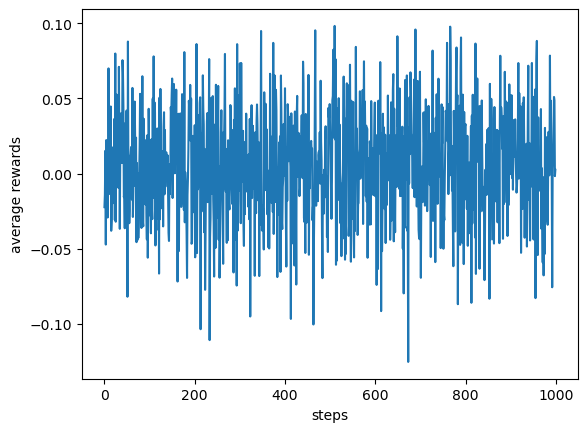

In [124]:
bg.run_n_sims(bg.iterate_all_actions, 1000, 1000, False)
bg.plot_average_rewards()


## Explore then exploit

In [112]:
@patch
def explore_then_exploit(self: BanditGame, exploration_factor: float):
    assert 0 <= exploration_factor and exploration_factor <= 1
    n_exploration_eps = self.n_episodes * exploration_factor
    if self.i_episode <= n_exploration_eps:
        return self.i_episode % self.env.action_space.n
    else:
        return self.average_rewards.argmax()


In [113]:
bg.run_n_episodes(bg.explore_then_exploit, 1000, False, [0.01])


1412.2532954445696

In [114]:
bg.run_n_sims(bg.explore_then_exploit, 1000, 1000, False, [0.01])


Average reward per sim is 1.1066768232646087 with sd 1.2796335360652666


array([[-2.75263468e+00, -1.29422918e+00, -4.84572805e-01, ...,
         1.43750084e+00,  1.42684607e+00,  2.16633847e-01],
       [-7.25795018e-01,  4.24154859e-01,  1.13131611e+00, ...,
        -5.08704909e-01,  1.26293249e+00, -7.09280140e-02],
       [-1.08831845e+00, -2.09504616e+00, -4.24316085e-01, ...,
         4.71272601e+00,  1.46688285e+00,  2.45279938e-01],
       ...,
       [-8.53678307e-01, -4.24040809e-01, -1.20731597e+00, ...,
         2.55584371e+00,  5.75529883e-01,  3.85198505e-03],
       [-1.20132597e+00,  1.54207417e+00, -3.68539897e-01, ...,
        -1.38413936e+00,  1.03278766e-01,  1.83961740e+00],
       [-2.38601438e+00,  7.54286135e-01,  8.17625836e-01, ...,
         1.68767688e-02, -9.10667640e-01,  1.11748891e+00]])

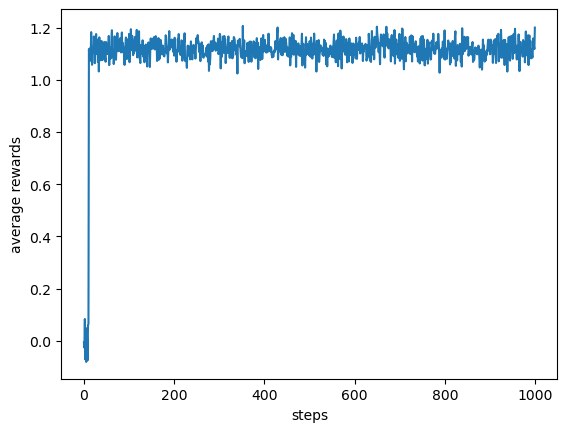

In [115]:
bg.plot_average_rewards()


rate: 0
Average reward per sim is 0.6662387073781215 with sd 1.242820280486222
rate: 0.001
Average reward per sim is 0.7131918355206157 with sd 1.2495003525458908
rate: 0.01
Average reward per sim is 1.1045630251765972 with sd 1.2927050087078373
rate: 0.03
Average reward per sim is 1.1790671902697818 with sd 1.2808302585816083
rate: 0.05
Average reward per sim is 1.207588978622696 with sd 1.2792519983878043
rate: 0.1
Average reward per sim is 1.1233584357653468 with sd 1.3055060820266093
rate: 0.2
Average reward per sim is 1.0026116214110277 with sd 1.380215541053634


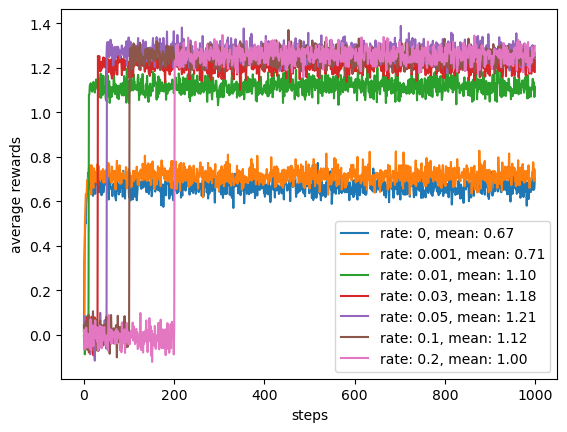

In [116]:
for rate in [0, 0.001, 0.01, 0.03, 0.05, 0.1, 0.2]:  # hyperparameter optimization
    print("rate:", rate)
    bg.run_n_sims(bg.explore_then_exploit, 1000, 1000, False, [rate])
    plt.plot(
        bg.average_rewards_per_episode,
        label=f"rate: {rate}, mean: {bg.reward_sims.mean():.2f}",
    )
    plt.ylabel("average rewards")
    plt.xlabel("steps")
plt.legend()
plt.show()

## Epsilon greedy

In [117]:
@patch
def epsilon_greedy(self: BanditGame, epsilon: float):
    assert 0 <= epsilon and epsilon <= 1
    if np.random.random() < epsilon:
        return np.random.randint(self.env.action_space.n)
    else:
        return self.average_rewards.argmax()


Average reward per sim is 0.6357125740551466 with sd 1.3047058103748603


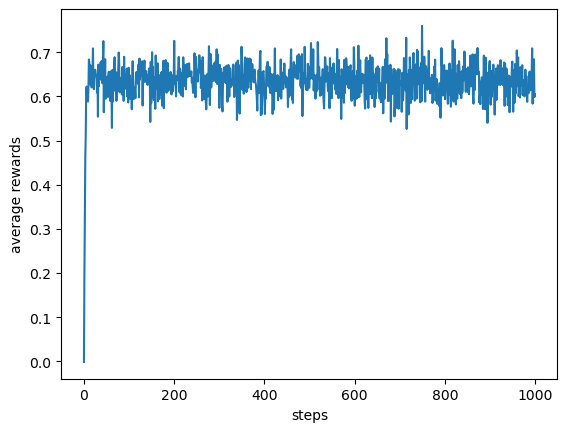

In [118]:
bg.run_n_sims(bg.epsilon_greedy, 1000, 1000, False, [0.1])
bg.plot_average_rewards()


rate: 0
Average reward per sim is 0.6648326884797604 with sd 1.2432390450490192
rate: 0.001
Average reward per sim is 0.7084862741871238 with sd 1.2475405947960372
rate: 0.01
Average reward per sim is 0.677267824127015 with sd 1.2581702415248115
rate: 0.03
Average reward per sim is 0.6972218206491403 with sd 1.27773679754357
rate: 0.05
Average reward per sim is 0.6353362770444292 with sd 1.2635858179103028
rate: 0.1
Average reward per sim is 0.6489683083933947 with sd 1.3029801788420075
rate: 0.2
Average reward per sim is 0.571174545041621 with sd 1.3142173860337083


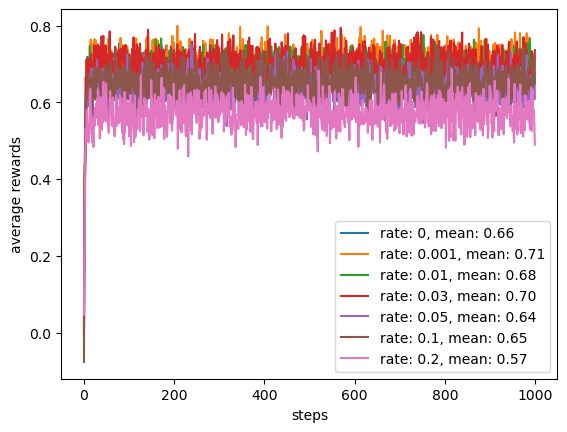

In [119]:
for rate in [0, 0.001, 0.01, 0.03, 0.05, 0.1, 0.2]:  # hyperparameter optimization
    print("rate:", rate)
    bg.run_n_sims(bg.epsilon_greedy, 1000, 1000, False, [rate])
    plt.plot(
        bg.average_rewards_per_episode,
        label=f"rate: {rate}, mean: {bg.reward_sims.mean():.2f}",
    )
    plt.ylabel("average rewards")
    plt.xlabel("steps")
plt.legend()
plt.show()

## Explore then exploit 2

In [139]:
@patch
def explore_then_exploit_with_weight(self: BanditGame, exploration_factor: float):
    assert 0 <= exploration_factor <= 1
    n_exploration_eps = self.n_episodes * exploration_factor
    if self.i_episode <= self.env.action_space.n:
        return self.i_episode % self.env.action_space.n
    elif self.i_episode <= n_exploration_eps:
        # random choice weighted by average reward
        weights = (self.average_rewards - np.min(self.average_rewards)) / (
            np.max(self.average_rewards) - np.min(self.average_rewards)
        )
        weights = weights / np.sum(weights)
        return np.random.choice(np.arange(self.env.action_space.n), p=weights)
    else:
        return self.average_rewards.argmax()

/Users/jonas/mambaforge/envs/MMDS/lib/python3.11/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/jonas/mambaforge/envs/MMDS/lib/python3.11/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/jonas/mambaforge/envs/MMDS/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/Users/jonas/mambaforge/envs/MMDS/lib/python3.11/site-package

Average reward per sim is 1.0542819099927787 with sd 1.2762373202230493


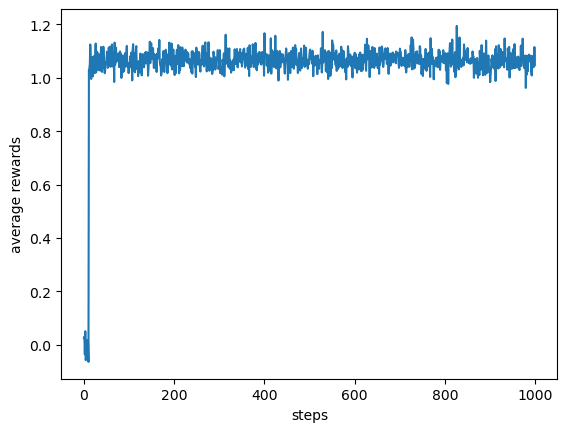

In [141]:
bg.run_n_sims(bg.explore_then_exploit_with_weight, 1000, 1000, False, [0.01])
bg.plot_average_rewards()


rate: 0
Average reward per sim is 1.0474251106306431 with sd 1.290023930229852
rate: 0.001
Average reward per sim is 1.053865730871972 with sd 1.2848342367439491
rate: 0.01
Average reward per sim is 1.0872645741627625 with sd 1.2776336645800437
rate: 0.03
Average reward per sim is 1.0366968744144944 with sd 1.2726963831935556
rate: 0.05
Average reward per sim is 1.0096678641828634 with sd 1.271927643021924
rate: 0.1
Average reward per sim is 1.0384142305075141 with sd 1.259477278840349
rate: 0.2
Average reward per sim is 1.000548358275061 with sd 1.2704206617423033
rate: 0.5
Average reward per sim is 0.9812954922724195 with sd 1.2701042158203275
rate: 1
Average reward per sim is 0.9905047773652113 with sd 1.2756780527402858


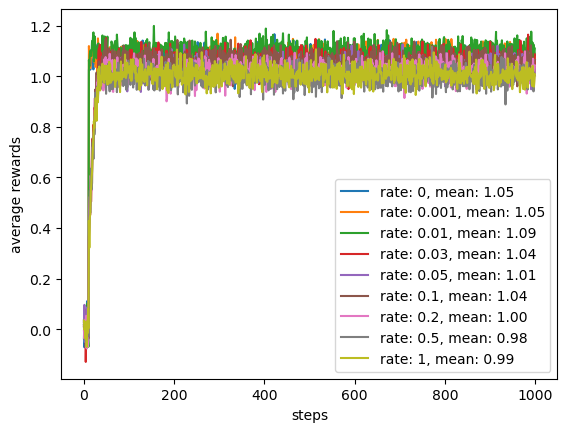

In [144]:
# hyperparameter optimization
for rate in [0, 0.001, 0.01, 0.03, 0.05, 0.1, 0.2, 0.5, 1]:
    print("rate:", rate)
    bg.run_n_sims(bg.explore_then_exploit_with_weight, 1000, 1000, False, [rate])
    plt.plot(
        bg.average_rewards_per_episode,
        label=f"rate: {rate}, mean: {bg.reward_sims.mean():.2f}",
    )
plt.ylabel("average rewards")
plt.xlabel("steps")
plt.legend()
plt.show()

## Compare strategies with optimal hyperparamers

iterate_all_actions
Average reward per sim is 6.633891629469505e-05 with sd 1.4182740306474266
explore_then_exploit
Average reward per sim is 1.1910860980303255 with sd 1.2852551261225498
epsilon_greedy
Average reward per sim is 0.6768878360993968 with sd 1.2755666528707652
explore_then_exploit_with_weight
Average reward per sim is 1.0199884835031996 with sd 1.263281567634277


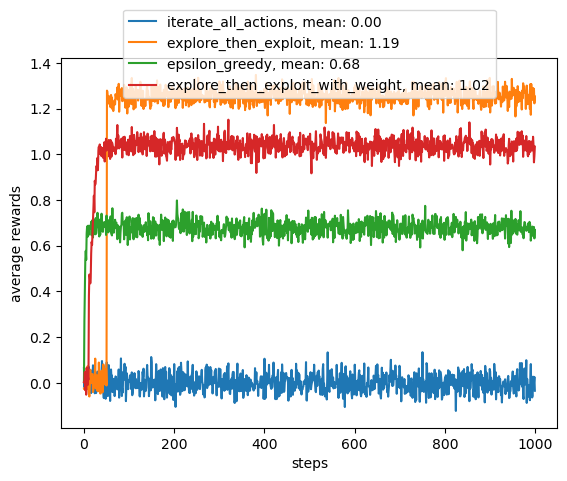

In [145]:
# run sims with all strategies
strategies = {
    "iterate_all_actions": bg.iterate_all_actions,
    "explore_then_exploit": bg.explore_then_exploit,
    "epsilon_greedy": bg.epsilon_greedy,
    "explore_then_exploit_with_weight": bg.explore_then_exploit_with_weight,
}
hyperparameters = {
    "iterate_all_actions": [None],
    "explore_then_exploit": [0.05],
    "epsilon_greedy": [0.01],
    "explore_then_exploit_with_weight": [0.1],
}
for strategy_name, strategy in strategies.items():
    print(strategy_name)
    bg.run_n_sims(strategy, 1000, 1000, False, hyperparameters[strategy_name])
    plt.plot(
        bg.average_rewards_per_episode,
        label=f"{strategy_name}, mean: {bg.reward_sims.mean():.2f}",
    )
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15))
plt.ylabel("average rewards")
plt.xlabel("steps")
plt.show()

Questions:
- how many rounds exploring is optimal?
- after a little exploration we should focus more onto the more promising ones